In [1]:
from IPython.display import Image

# Data Exploration: Leela Shah and Subani Adhikari
## PSYC 5270: Computational Neuroscience

## Introduction

In this data exploration project, we began preliminary analysis for exploration of the neural computations involved in the prefrontal cortex (PFC) during working memory tasks. Specifically, we were interested in the computations involved in the PFC and between the PFC and other cortical areas during working memory tasks.


## Background

**Our data set:** 
 - Our data set contains a comparison of EEG recordings from PFC-damaged patients and healthy control participants.
 - In Johnson et al.(2017), the researchers suggest that parallel, bidirectional oscillatory systems between the PFC and other    cortical regions form the basis of working memory.(1)


**Knowns and Unknowns:**
 - Traditional research shows that the PFC is active during working memory computations, suggesting a major role for this    
   cortical region in the neural computations involved in working memory.
 - The PFC alone has traditionally been associated with working memory computations.
 - It is unknown what the roles of other cortical structures are.
 - It is unknown how the PFC communicates with these structures during working memory tasks. 



**Hypothesis:** 
 - We hypothesize that the behavior of the PFC during working memory can be approximated by a dynamical neural system in which the PFC oscillates between two equilibria - one in which the PFC functions independently and one in which the PFC interacts with other brain regions. This hypothesis is based on similar findings in Mayo et. al (2020) that suggest that a dynamical neural system with two stable equilibria can be used to describe social engagement.(2)


**Specific Goal:** 
 - Our specific aim was to explore the preprocessing of data files from our two data sets. 
 - This included loading data, filtering data, removing bad channels, and applying independent component analysis (ICA) to our    data.

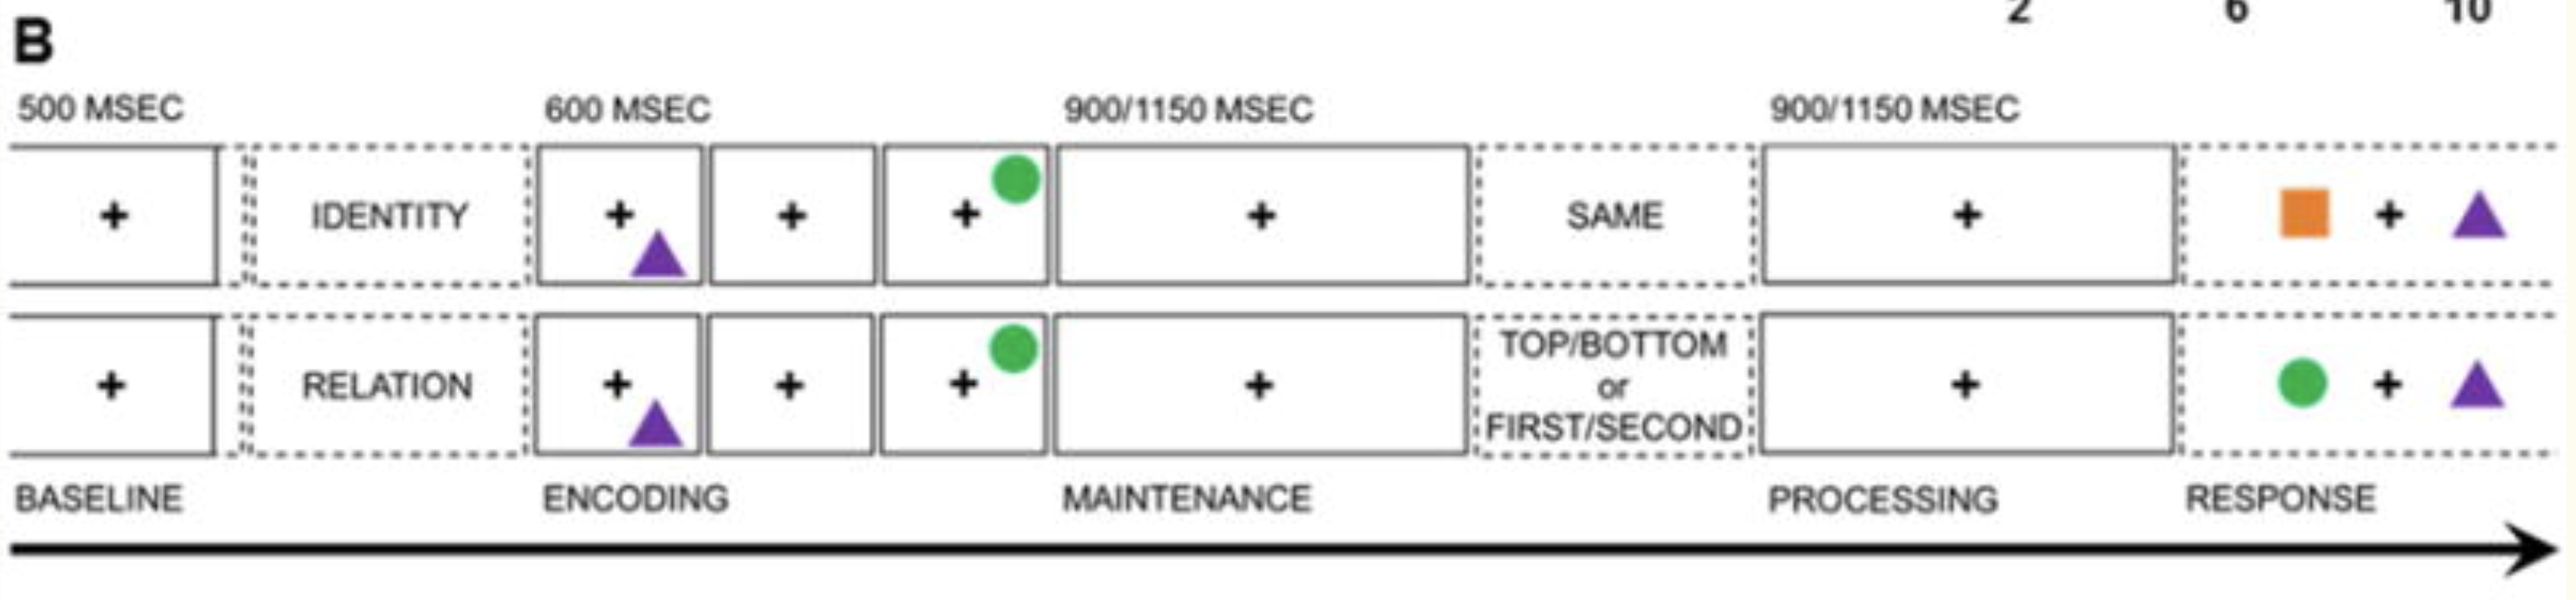

In [2]:
Image("Johnson et al image.png")

## Methods

 - The data set we processed contains primary (raw) human scalp EEG recordings in .bdf (BioSemi) format from 14 patients with unilateral prefrontal cortex lesions, and from 20 healthy control participants. 
 - We used MNE, an open-source Python software for analyzing EEG data, to preprocess the raw data.(3)

**Experimental Equipment:**
 - Human scalp EEG data was collected using a 64 + 8 channel BioSemi ActiveTwo amplifier and Ag-AgCl pin-type active electrodes mounted on an elastic cap. 
 - Data were sampled at 1024 Hz.

**Experimental Design:**
 - Each trial consisted of five phases: pre-trial→ encoding→  maintenance→ active processing→ response 
 - Participants completed 120-240 trials
 - **Pre-trial** 
     - 2 second pretrial fixation interval
     - Participant fixates on center of screen
 - **Encoding** 
     - participants asked to focus on either IDENTITY or RELATION information (what shape, or which shape was presented first)
     - Then, two shapes were presented for 200 ms each to the left or right visual hemifield in a specific  - spatiotemporal configuration 
     - i.e., top/bottom spatial and first/second temporal positions
 - **Maintenance** 
     - 900 or 1150 millisecond jittered maintenance fixation interval
     - Then, the test prompt appears
 - **Active Processing**
     - 900 or 1150 millisecond processing interval 
 - **Response**
     - Identity test-- subjects indicated whether the pair was the SAME pair they just studied 
     - Spatiotemporal relation test-- subjects indicated which shape fit the TOP/BOTTOM spatial or FIRST/SECOND temporal relation prompt 





 

One technique that we will focus on today is repairing artifacts with ICA, and how this technique relates to our objectives and aims for this project. 

What are artifacts?

 - **Artifacts** are components of the recorded signal that arise from sources other than the source of interest (i.e., neuronal activity in the brain). They account for the “noise” in our data. 
 - There are three main sources of artifacts:
     - **Environmental artifacts**: Signals due to interference from environmental factors such as building vibrations, field noise from nearby elevators, cell phones, AC power line frequency, and other sources
     - **Instrumentation artifacts**: Result from interference from stimulus presentation and random noise in a channel due to sensor malfunctions such as poor scalp contact of electrodes. 
     - **Biological artifacts**: Result from signal patterns from electrical activity of the heart, eye movements, muscular activity during swallowing. 

 - When faced with artifacts in our signal recording, we can either ignore them, exclude them, or repair them. By repairing artifacts, we can suppress the interference while maintaining the signal of interest. We used the MNE package to implement Independent Component analysis (ICA) to repair the artifacts in our data set. 


Independent Component Analysis

 - **Independent Component Analysis (ICA)** is a technique used to estimate independent source signals from recordings and repair artifacts. ICA can thus be used to separate EEG data from artifacts such as heart beats and eye blinks. 
 - Steps:
     - Using the MNE-Python package, the data are scaled and whitened using **principal components analysis (PCA)**. 
         - PCA is an algorithm that identifies directions along with the variation in the data is maximal and uses this information to scale the data while retaining its variability. (4) 
     - The first n components of the PCA (as identified by the user) are then passed into the ICA algorithm to separate the components of the signal. 
     - The user then identifies the components that contain artifacts and labels these components to be excluded. 
     - Then, the MNE package can essentially subtract the artifact-containing components from the data, effectively removing the artifacts while preserving the EEG signal.

In [3]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import rise
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

Step 1: Loaded the data using MNE, a Python package designed for MEG and EEG data visualization

Step 2: Chose a duration of time during which the study had begun, to avoid noise during setup

In [44]:
#loaded the data
def load_data(filename):
    data_folder = os.path.join("data", filename)
    file_to_open = os.path.join(data_folder, "data_primary.bdf")
    raw = mne.io.read_raw_bdf(file_to_open, eog=None, misc=None, stim_channel='auto', exclude= 'None', preload=False, verbose=None)
    return raw 

filename = "ctrl01"
raw = load_data("ctrl01")
print(raw)
print(raw.info)
raw.crop(tmax=54.022)

Extracting EDF parameters from C:\Users\leela\crcns-fc3-ls2km-sa2dy\data\ctrl01\data_primary.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
<RawEDF | data_primary.bdf, 73 x 2682880 (2620.0 s), ~143 kB, data not loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 208.0 Hz
 meas_date: 2014-11-19 16:08:43 UTC
 nchan: 73
 projs: []
 sfreq: 1024.0 Hz
>


<RawEDF | data_primary.bdf, 73 x 55320 (54.0 s), ~143 kB, data not loaded>

Step 3: Visualized the data as a power spectral density (PSD) plot

Effective window size : 2.000 (s)


<ipython-input-45-edbd5d4bb9e0>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd()


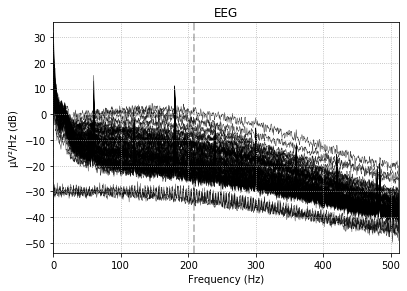

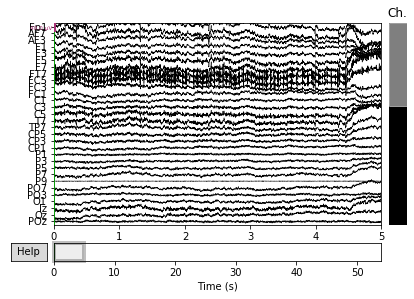

In [45]:
#visualize the data
def psd_plot(data, duration=5, n_channels =30):
  data.plot_psd()
  data.plot(duration=duration, n_channels=n_channels)

data = raw
psd_plot(data)

Step 4: Removed bad channels

In [46]:
#remove bad channels
def exclude_bad_channels(data,bad_channels):
    data.info['bads'].extend(bad_channels)
    good_eeg = mne.pick_types(raw.info, meg=False, eeg = True)
    all_eeg = mne.pick_types(raw.info, meg=False, eeg=True, exclude=[])
    return(good_eeg, all_eeg)

drop = ['P9', 'Fpz','Fz']
good_eeg, all_eeg = exclude_bad_channels(raw, drop)

Step 5: Filtered the data as defined in the paper to 1-40 Hz, in order to capture individual variability in alpha peak frequency

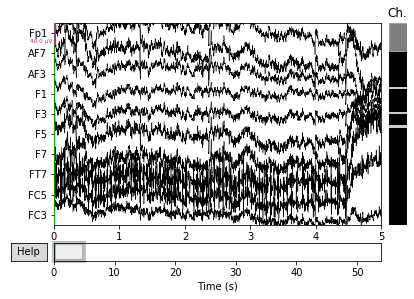

Reading 0 ... 55319  =      0.000 ...    54.022 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3379 samples (3.300 sec)



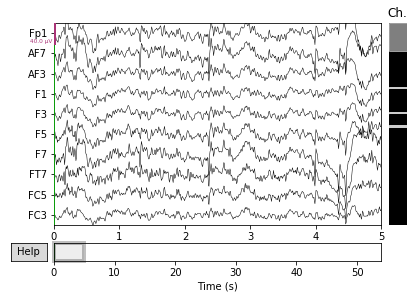

Effective window size : 2.000 (s)


<ipython-input-45-edbd5d4bb9e0>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd()


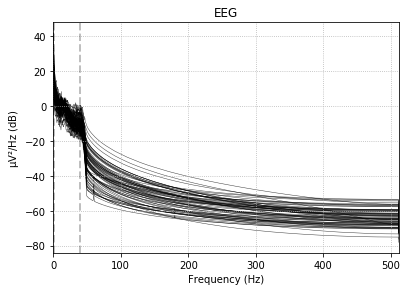

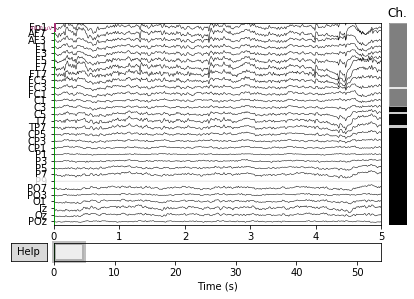

In [47]:
#filtering data to remove slow drifts

def filter(data,duration=5,n_channels=10,l_freq=1,h_freq=40): 
    data.plot(duration=duration, n_channels=n_channels)
    data.load_data().filter(l_freq=l_freq, h_freq=h_freq)
    data.plot(duration=duration, n_channels=n_channels)

data=raw
filter(raw)
psd_plot(data)

Step 6: Fit the ICA to our data

Fitting ICA to data using 69 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Fitting ICA took 1.6s.


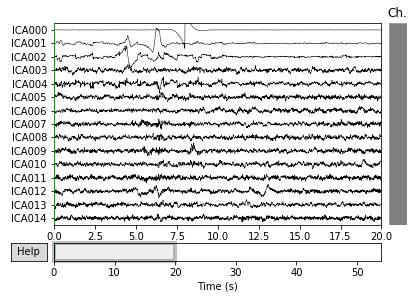

In [48]:
#fit the ICA
def ica_fit(data,components):
    ica = ICA(n_components=components, random_state=97)
    ica.fit(data)
    ica.plot_sources(data)
    return ica
data=raw
components=15
ica = ica_fit(data,components)

Transforming to ICA space (15 components)
Zeroing out 1 ICA component


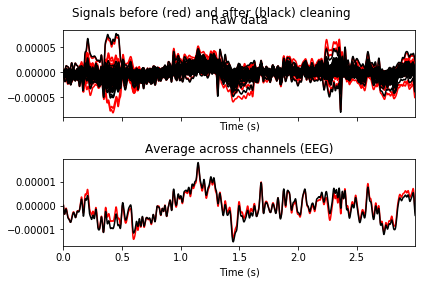

Transforming to ICA space (15 components)
Zeroing out 1 ICA component


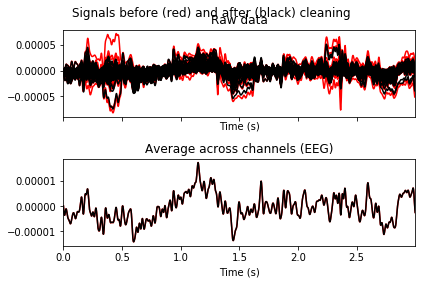

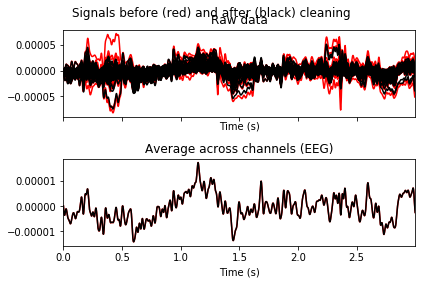

In [59]:
#visualize different ICA components
ica.plot_overlay(raw, exclude=[1], picks='eeg')
ica.plot_overlay(raw, exclude=[2], picks='eeg')

Step 7: Applied the ICA to our data

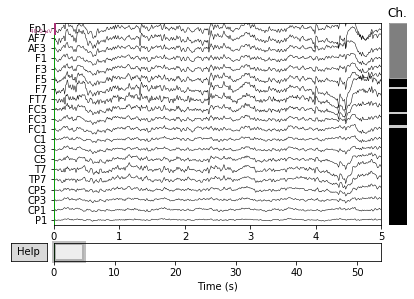

Transforming to ICA space (15 components)
Zeroing out 2 ICA components


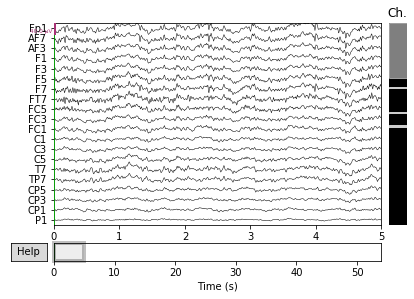

In [60]:
#apply the ICA
def ica_apply(data,exclude,duration=5,n_channels=20):
    data.plot(duration=duration, n_channels=n_channels)
    ica.exclude = exclude
    ica.apply(data)
    data.plot(duration=5, n_channels=20) 
data=raw
exclude = [1,2]
ica_apply(data,exclude)

Effective window size : 2.000 (s)


<ipython-input-6-edbd5d4bb9e0>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd()


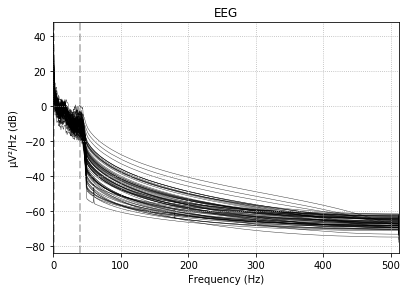

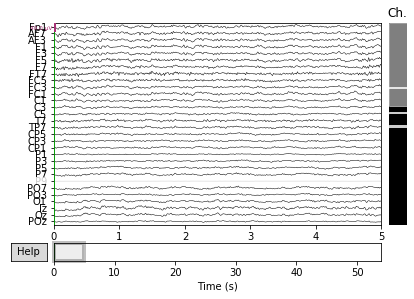

In [12]:
#plot the data again
data = raw
psd_plot(data)

Extracting EDF parameters from C:\Users\leela\crcns-fc3-ls2km-sa2dy\data\pfc02\data_primary.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
<RawEDF | data_primary.bdf, 73 x 1794048 (1752.0 s), ~143 kB, data not loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 208.0 Hz
 meas_date: 2014-12-02 13:01:32 UTC
 nchan: 73
 projs: []
 sfreq: 1024.0 Hz
>
Effective window size : 2.000 (s)


<ipython-input-6-edbd5d4bb9e0>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.plot_psd()


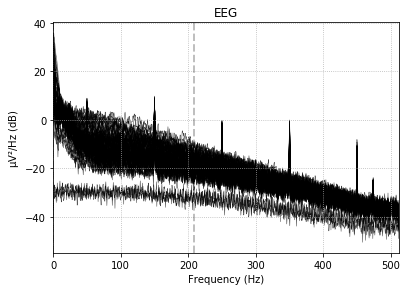

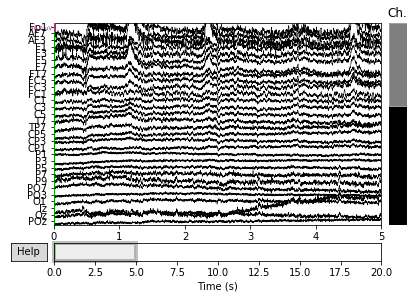

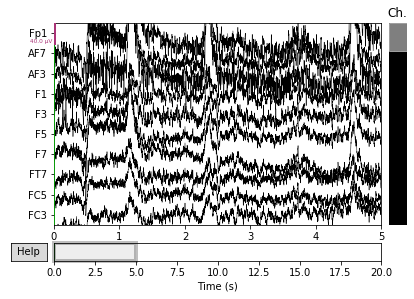

Reading 0 ... 20480  =      0.000 ...    20.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3379 samples (3.300 sec)



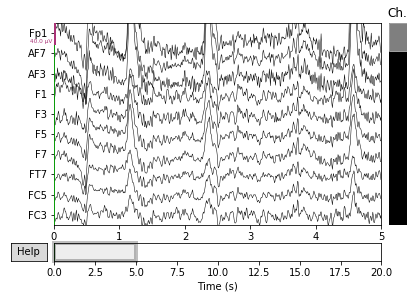

In [13]:
#do the same for the pfc patient dataset

#load the data
filename = "pfc02"
raw2 = load_data("pfc02")
print(raw2)
print(raw2.info)
raw2.crop(tmin=980,tmax=1000)

#plot the data
data = raw2
psd_plot(data)

#no bad channels in this data set

#filtering data to remove slow drifts
data = raw2
filter(data)

Fitting ICA to data using 72 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Fitting ICA took 0.8s.


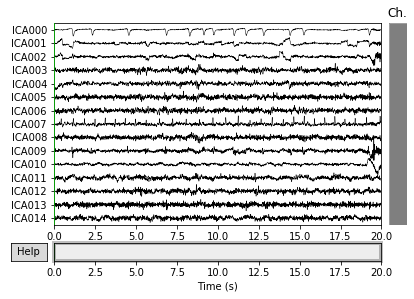

<ICA  |  raw data decomposition, fit (fastica): 20481 samples, 15 components, channels used: "eeg">

In [14]:
#fit the ICA
data=raw2
components=15
ica_fit(data,components)

Transforming to ICA space (10 components)
Zeroing out 5 ICA components


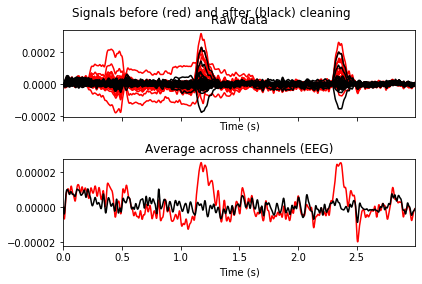

Transforming to ICA space (10 components)
Zeroing out 5 ICA components


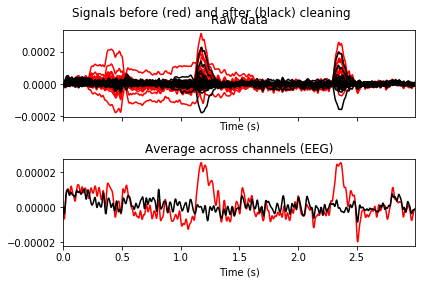

Transforming to ICA space (10 components)
Zeroing out 4 ICA components


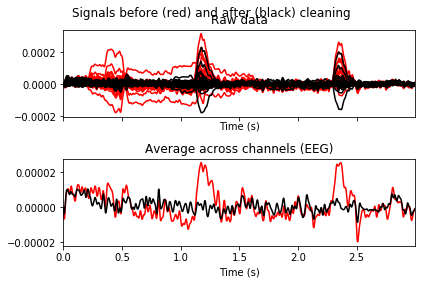

Transforming to ICA space (10 components)
Zeroing out 4 ICA components


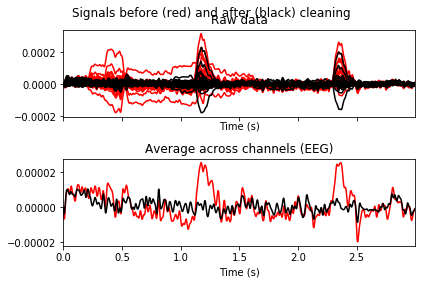

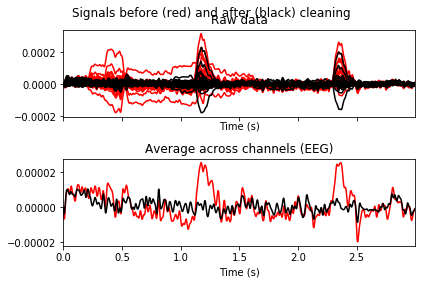

In [15]:
#visualize different ICA components
ica.plot_overlay(raw2, exclude=[0], picks='eeg')
ica.plot_overlay(raw2, exclude=[7], picks='eeg')
ica.plot_overlay(raw2, exclude=[1], picks='eeg')
ica.plot_overlay(raw2, exclude=[4], picks='eeg')

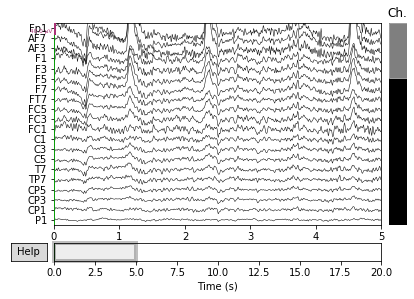

Transforming to ICA space (10 components)
Zeroing out 4 ICA components


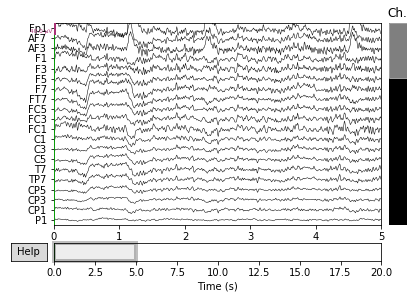

In [16]:
#apply the ICA
data = raw2
exclude = [0,7,1,4]
ica_apply(data,exclude)

## Results

Let's show the final output of our data (e.g., a time series for each data set post-ICA)

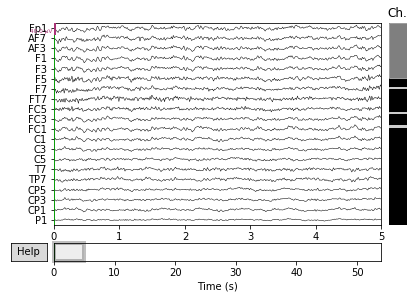

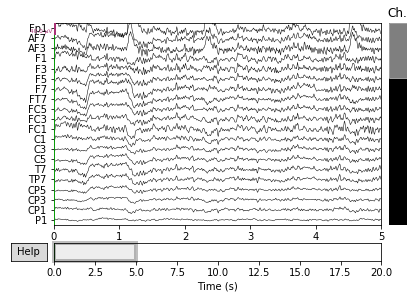

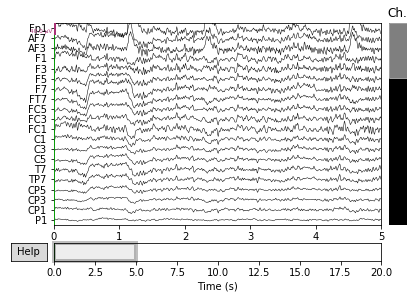

In [19]:
#compare the two

#Control Subject 1
raw.plot(duration=5, n_channels=20)

#PFC Subject 2
raw2.plot(duration=5, n_channels=20)

 - What we have now are clean, preprocessed datasets that can be used for other types of analysis
 - In the current state, these plots cannot be compared. The differences that we can make out are due to noise or other factors

## Discussion

 - Preprocessing is a crucial first step for data analysis.
 - These steps are important to ensure that differences in data are due to differences in neuronal activity, not environmental noise
 - Limitations:
     - This data set, unlike many others, did not contain specific channels designated as EOG (electrooculogram) or ECG (electrocardiogram) channels. Thus, rather than defaulting to those channels to use in the ICA, we had to estimate which ICA components contained artifacts by plotting the components.
      - It was also difficult to identify the components to exclude for the ICA for the first control subject. This could be due to smaller artifacts in this dataset than in the pfc subject dataset.
      - Although we extensively preprocessed the data, it is still not at a state where the two plots can be compared.
 - Next steps:
     - Compare ERPs (event related potentials) during specific epochs
     - Describe the trials included in our data set
     - Describe how this data could be used to inform our hypothesis



## Acknowledgements
The entirety of the data analysis for this project was carried out using the MNE python EEG and MEG analysis package.3 The code is also based on Python code presented by the MNE creators in the tutorials provided on the MNE website. (5) Links to specific tools are included in the References section (6,7). Lastly, we would like to thank Daniel Meliza for his support and expertise in the theory and implementation of computational neuroscience techniques throughout the completion of this project.

## Questions?

## References
1) Johnson (2017); 64-channel human scalp EEG from 14 unilateral PFC patients and 20 healthy controls performing a lateralized visuospatial working memory task. CRCNS.org
http://dx.doi.org/10.6080/K0ZC811B

2) Mayo, O. & Gordon, I. In and out of synchrony—Behavioral and physiological dynamics of dyadic interpersonal coordination. Psychophysiology n/a, e13574.

3) A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, L. Parkkonen, M. Hämäläinen, MNE software for processing MEG and EEG data, NeuroImage, Volume 86, 1 February 2014, Pages 446-460, ISSN 1053-8119, [DOI]

4) Ringnér, M. What is principal component analysis?. Nat Biotechnol 26, 303–304 (2008). https://doi.org/10.1038/nbt0308-303

5) A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X, [DOI]

6) Repairing artifacts with ICA- MNE.tools
